# Event Centering 2021-04-14

Goal of this notebook is to test out functions for event centering on 1 day, 1 neuron. And then, 1 day, all neurons. And then all days all neurons. Plan is to save out as dicts (nested) to used for later analysis specific to delay period analysis.

### Libs & Utils

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
from tqdm import tqdm
from scipy import stats
# stored one repo up in my fork of Spykes
# from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

### Load session

Here, I'm loading in one session (08-06-2019) that has 4 cells 

In [2]:
sess_name = 'W122_08_06_2019_1_fromSD'

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'

# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
# fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)
sess_aligned = event_align_session(spks_dict, beh_df, sess_path)

loading from file...


In [4]:
sess_aligned[0].keys()

dict_keys(['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 'delay2s', 'trial2s', 'delay4s', 'trial4s'])

In [52]:
neuron_t = split_spks_by_trial(spks_dict['spk_times'][0], beh_df)
neuron_a = sess_aligned[0]

### Rasters

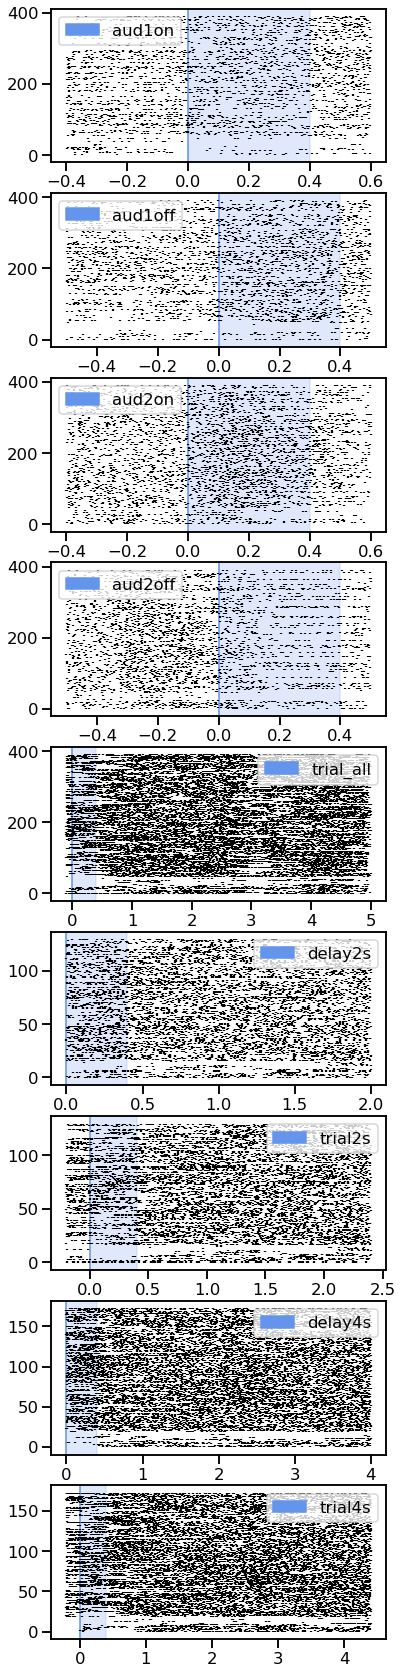

In [65]:
fig, ax = plt.subplots(len(neuron_a), 1, figsize=(6,30))

for idx, key in enumerate(neuron_a.keys()):
    _ = ax[idx].eventplot(neuron_a[key],colors = 'black')
    ax[idx].axvspan(0,0.000001, color = 'cornflowerblue', label = key)
    ax[idx].axvspan(0,0.4, alpha = 0.2, color = 'cornflowerblue')
    ax[idx].legend()
    

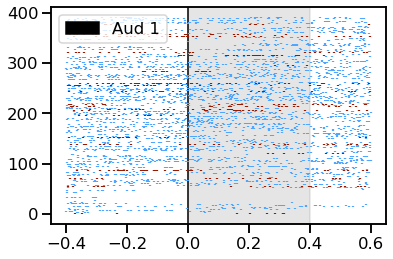

In [111]:
t = (beh_df['hit_hist'] =='hit').to_numpy()
new = np.where(t == True, '#4DA6FF', '#991900')

_ = plt.eventplot(neuron_a['aud1on'], color = new)
plt.axvspan(0,0.4, alpha = 0.2, color = 'grey')
plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
plt.legend()

### PSTHs

Stopped here--- TODO:

* adjust get_spike_counts to work on event centered data
* once binarized, implement guassian convolution for 1 event/neuron
* deal w/ masking
* expand to multiple events
* expand to splitting by conditions
* expand to multiple neurons
* expand to multiple sessions

In [6]:
30000 * 60 * 5

9000000

In [39]:
n =2
t1 = 1500
t2 = t1 + 5
five_min = spks_dict['spk_times'][n][np.logical_and(spks_dict['spk_times'][n] < t2, spks_dict['spk_times'][n] > t1)]

0.01933264601105596

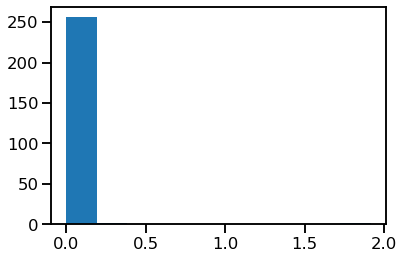

In [40]:
plt.hist(np.diff(five_min))
np.mean(np.diff(five_min))

In [28]:
np.mean(np.diff(five_min))

0.011073267838355605

In [44]:
len(sess_aligned[0]['aud1on'])

392

In [86]:
"need to document"
def binarize_event(event_aligned_spks, window, bin_size):
    
    binarized_spks = []
    half_bin = bin_size / 2
    bin_centers = np.arange((window[0] * 0.001) + half_bin, (window[1] * 0.001), bin_size)
    n_bins = len(bin_centers)
    
    for trial_spks in range(300):
        
        binarized_trial = np.zeros((n_bins))
        
        for ibin in range(n_bins):
            
            spk_in_ibin = np.logical_and(event_aligned_spks[trial_spks] >= (bin_centers[ibin] - half_bin),
                                        event_aligned_spks[trial_spks] <= (bin_centers[ibin] + half_bin))
            
            if np.sum(spk_in_ibin) > 0:
                binarized_trial[ibin] = 1
                
        binarized_spks.append(binarized_trial)
            
    return binarized_spks
            

In [114]:
test = binarize_event(sess_aligned[0]['aud1on'],[-400, 600], 0.001)

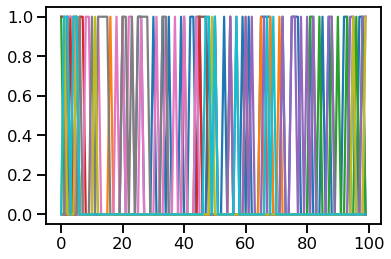

In [83]:
for i in range(10):
    plt.plot(test[i])

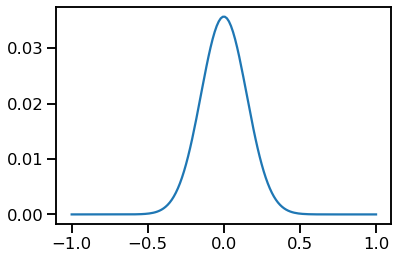

In [105]:
def gaussian(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1/2 * ((x - mu)/sigma)**2)

def exponential(x, tau):
    return np.exp(-x / tau)


mu = 0
sigma = .150

x = np.linspace(-1.0, 1.0, 150)
kernal = gaussian(x, mu, sigma)
kernal_normalized = kernal/np.sum(kernal)
plt.plot(x, kernal_normalized)


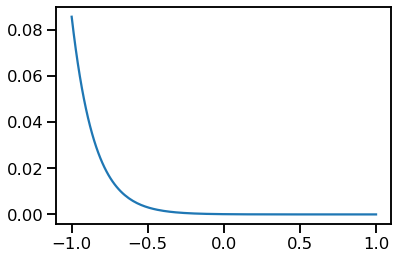

In [104]:
x = np.linspace(-1.0, 1.0, 150)
kernal = exponential(x, sigma)
kernal_normalized = kernal/np.sum(kernal)
plt.plot(x, kernal_normalized)

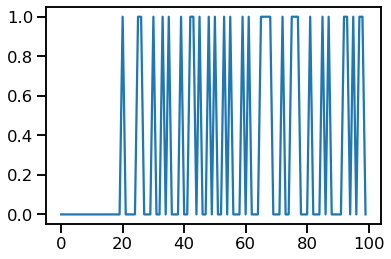

In [95]:
plt.plot(test[0])

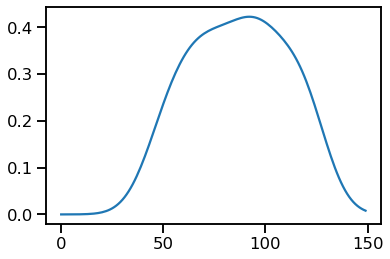

In [107]:
plt.plot(np.convolve(test[0], kernal_normalized, mode = 'same'))

In [122]:
time = np.linspace(-400 ,  600, len(test_mean))

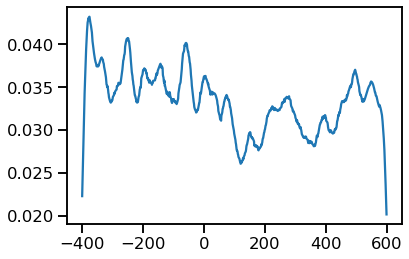

In [127]:
plt.plot(time, test_mean)

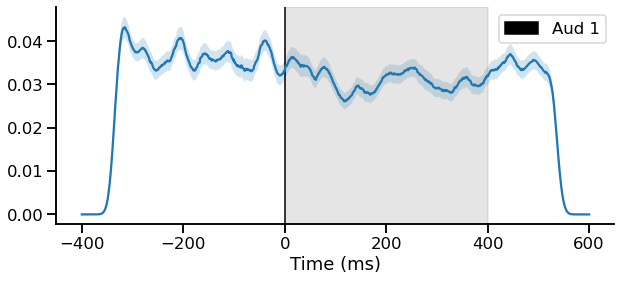

In [136]:
conv_trial= []

for trial in test:
    smoothed = np.convolve(trial, kernal_normalized)
    smoothed = np.where(smoothed == 0, np.nan, smoothed)
    conv_trial.append(smoothed)
    
conv_trial = np.array(conv_trial)

test_mean = np.nanmean(conv_trial, axis=0)
test_sem = stats.sem(conv_trial, axis=0, nan_policy='omit')

time = np.linspace(-400 ,  600, len(test_mean))

fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(time, test_mean)
ax.fill_between(time, test_mean - test_sem, test_mean + test_sem, alpha = 0.2 )

plt.axvspan(0,400, alpha = 0.2, color = 'grey')
plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
ax.set(xlabel = "Time (ms)")
plt.legend()
sns.despine()

## non function code

In [59]:
# these are names in the beh_df
df_event = ['aud1_on', 'aud1_off', 'aud2_on', 'aud2_off', 'aud1_on']
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000]]


aligned_spk_times = {}

for event,name,window in zip(df_event,names,windows):
    rowsL = []
    aligned_spk_times[name] = []
    
    for itrial, row in beh_df.iterrows():
        
        trial_spks = neuron1_spks['trial_spks'][itrial]

        # grab alignment time
        align_time = row[event]
        
        # create windows
        start = align_time + (window[0] * 0.001)
        stop  = align_time + (window[1] * 0.001)  
        
         # grab spks in the window
        spks_in_window = trial_spks[np.logical_and(trial_spks > start, trial_spks < stop)]
        event_aligned = spks_in_window - align_time
        
        # append
        aligned_spk_times[name].append(event_aligned)
        

In [102]:
# delay

def delay_align(beh_df, trial_spks):
    delay_windows = [[0, 2000],[-200, 2400], [0, 4000], [-200, 4400]]
    delay_names = ['delay2s', 'trial2s', 'delay4s', 'trial4s']


L =[[],[],[],[]]


    for itrial, row in beh_df.iterrows():

        trial_spks = neuron1_spks['trial_spks'][itrial]
        d_align_time = row['aud1_off']
        t_align_time = row['aud1_on']

        if row['delay'] == 2:

            d = 0
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 1
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)

        elif row['delay'] == 4:

            d = 2 
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 3
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)


    delay_info = dict(zip(delay_names, L))